In [1]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

figsize = (12,6)
ttl_font_size = 20
lgd_font_size = 14
big_marker_size = 14
med_marker_size = 10
sml_marker_size = 8
marker_edge_width = 1.5
lw = 1

# import autograd.numpy as np
# from autograd import grad
# import cvxpy as cp

# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
# import matplotlib.pyplot as plt

# figsize = (5,2.5)
# ttl_font_size = 11
# lgd_font_size = 7
# big_marker_size = 8.5
# med_marker_size = 6
# sml_marker_size = 4
# marker_edge_width = 0.75
# lw = 0.5

# 1) Data

- We will use real-world demographic data taken from LandScan [1].


- The desired information pertaining to the population of the city of Rio de Janeiro has been extracted by the ModSiming team from UFRJ [2].

[1] https://landscan.ornl.gov/

[2] https://github.com/ModSiming/EpiSiming

In [2]:
landscan_rio = np.load('landscan_rio_paqueta.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)
landscan_rio_xscale = 0.85239
landscan_rio_yscale = 0.926
landscan_rio_ydim, landscan_rio_xdim = landscan_rio.shape

print(f'Block matrix dimension: {landscan_rio.shape}')
print(f'Total blocks: {landscan_rio_xdim*landscan_rio_ydim}')
print(f'Total inhabited blocks: {len(landscan_rio[landscan_rio>0])}')

Block matrix dimension: (39, 83)
Total blocks: 3237
Total inhabited blocks: 1473


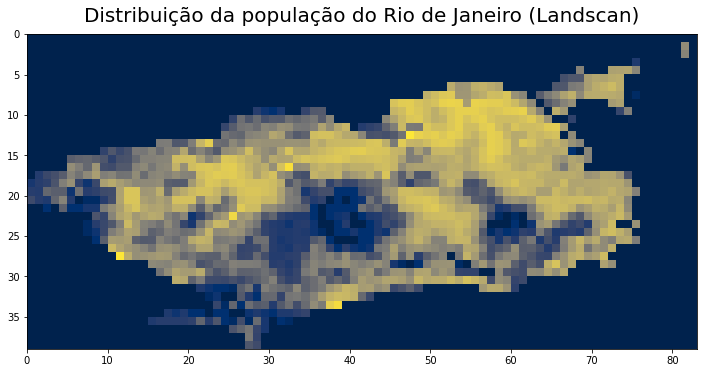

In [3]:
landscan_rio_plot = landscan_rio
landscan_rio_plot[np.where(landscan_rio == np.sort(landscan_rio.ravel())[-1])] = np.sort(landscan_rio.ravel())[-2]
landscan_rio_plot = np.log(1 + landscan_rio_plot) + 0.000_1*landscan_rio_plot

plt.figure(figsize = figsize)
ext = [0, landscan_rio_xdim, landscan_rio_ydim, 0]
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.title("Distribuição da população do Rio de Janeiro (Landscan)", fontsize = ttl_font_size, y = 1.02)
plt.savefig("pop_RJ.pgf", bbox_inches = 'tight')

# 2) Linear signal decay (concave objective function)

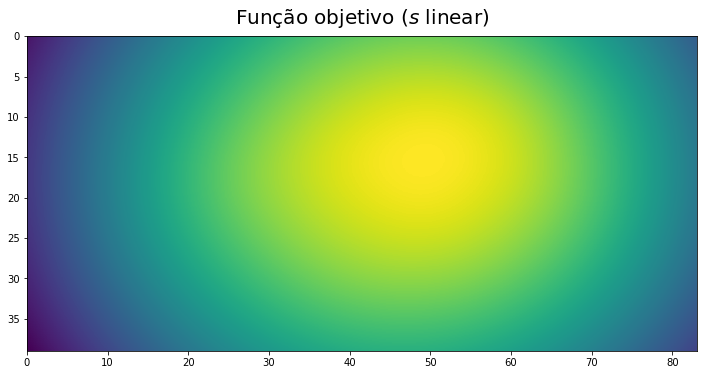

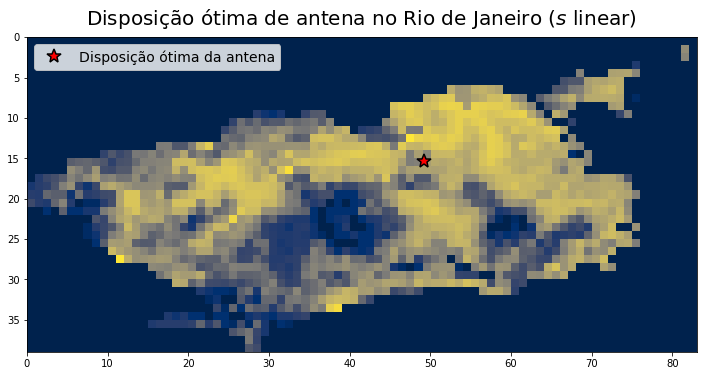

In [4]:
pts_x = np.arange(landscan_rio_xdim)
pts_y = np.arange(landscan_rio_ydim)
pts_x_meshgrid, pts_y_meshgrid = np.meshgrid(pts_x, pts_y)
all_pts = np.column_stack((pts_x_meshgrid.ravel(), pts_y_meshgrid.ravel()))

landscan_rio_flat = landscan_rio.ravel()

all_pts = all_pts[landscan_rio_flat > 0]
landscan_rio_flat = landscan_rio_flat[landscan_rio_flat > 0]

xy_scale = np.diag([landscan_rio_xscale, landscan_rio_yscale])

def d_to_all_pts(v): return np.linalg.norm((all_pts - v) @ xy_scale, axis = 1)
def s(d): return -d

def f_obj(v): return s(d_to_all_pts(v)) @ landscan_rio_flat

M = 200
N = 200
X = np.linspace(0, landscan_rio_xdim, M)
Y = np.linspace(0, landscan_rio_ydim, N)

F = np.reshape([f_obj(np.array([x,y])) for y in Y for x in X], (M,N))

plt.figure(figsize = figsize)
plt.imshow(F, extent = ext)
plt.title("Função objetivo ($s$ linear)", fontsize = ttl_font_size, y = 1.02);
plt.savefig("f_obj_s_lin.pgf", bbox_inches = 'tight')

var = cp.Variable(2)

res_x_1 = (var[0] >= 0); res_x_2 = (var[0] <= landscan_rio_xdim-1)
res_y_1 = (var[1] >= 0); res_y_2 = (var[1] <= landscan_rio_ydim-1)
res = [res_x_1, res_x_2, res_y_2, res_y_2]

def d_to_all_pts(v): return cp.norm((all_pts - np.ones_like(all_pts) @ cp.diag(v)) @ xy_scale, axis = 1)
f_obj =  s(d_to_all_pts(var)) @ landscan_rio_flat

pb = cp.Problem(cp.Maximize(f_obj), res)
pb.solve()

loc_opt_lin = np.array(var.value)

plt.figure(figsize = figsize)
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_lin[0], loc_opt_lin[1], '*', color = 'red', markersize = big_marker_size, markeredgecolor = 'black',
         markeredgewidth = marker_edge_width, label = "Disposição ótima da antena")
plt.title("Disposição ótima de antena no Rio de Janeiro ($s$ linear)", fontsize = ttl_font_size, y = 1.02)
plt.legend(loc = 'upper left', fontsize = lgd_font_size)
plt.savefig("loc_opt_s_lin.pgf", bbox_inches = 'tight')

# 3) Exponential signal decay (non-convex/concave objetive funtion)

In [5]:
def d_to_all_pts(v): return np.linalg.norm((all_pts - v) @ xy_scale, axis = 1)
c = 0.1
def s(d): return np.exp(-c*d)

def f_obj(v): return s(d_to_all_pts(v)) @ landscan_rio_flat
grad_f = grad(f_obj)

M = 200
N = 200
X = np.linspace(0, landscan_rio_xdim, M)
Y = np.linspace(0, landscan_rio_ydim, N)

F = np.reshape([f_obj(np.array([x,y])) for y in Y for x in X], (M,N))

## 3.2) Gradient "ascent"

In [6]:
def f_obj(v):
    log_barrier = np.sum(np.log(np.hstack([v, np.array([landscan_rio_xdim, landscan_rio_ydim]) - v])))
    return s(d_to_all_pts(v)) @ landscan_rio_flat + log_barrier
grad_f = grad(f_obj)


loc_curr = np.array([30.001, 30.001])
f_obj_loc_curr = f_obj(loc_curr)
grad_f_loc_curr = grad_f(loc_curr)
λ = 1e-3
locs = loc_curr

for i in range(100):
    loc_next = loc_curr + λ*grad_f_loc_curr

    if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim] - loc_next)]) <= 0):
        f_obj_loc_next = -np.inf
    else:
        f_obj_loc_next = f_obj(loc_next)
    
    while f_obj_loc_next < f_obj_loc_curr:
        λ = λ/2
        loc_next = loc_curr + λ*grad_f_loc_curr
        
        if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim] - loc_next)]) <= 0):
            f_obj_loc_next = -np.inf
        else:
            f_obj_loc_next = f_obj(loc_next)
    
    if np.linalg.norm(loc_curr - loc_next) < 1e-3:
        break
        
    loc_curr = loc_next
    f_obj_loc_curr = f_obj_loc_next
    grad_f_loc_curr = grad_f(loc_curr)
    λ = λ*2
    
    locs = np.vstack([locs, loc_curr])
    
print("len(locs) =", len(locs))

len(locs) = 10


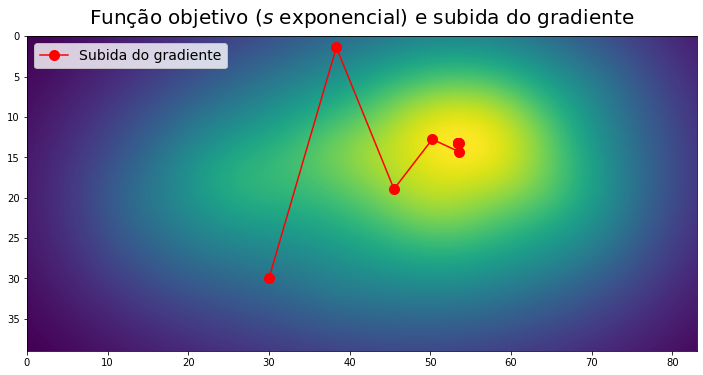

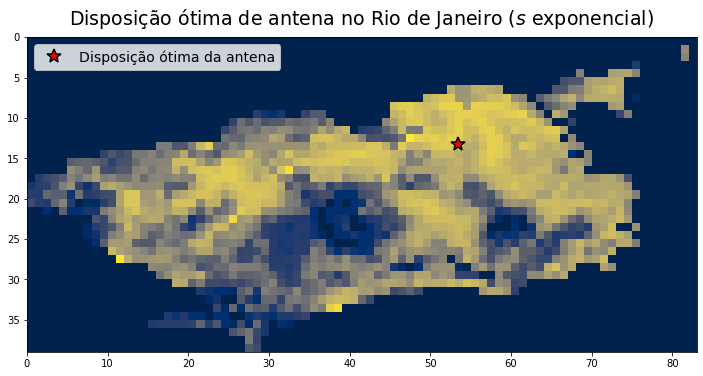

In [7]:
plt.figure(figsize = figsize)
plt.imshow(F, extent = ext)
plt.plot(locs[:,0], locs[:,1], marker = 'o', color = 'r', markersize = med_marker_size, label = "Subida do gradiente")
plt.title("Função objetivo ($s$ exponencial) e subida do gradiente", fontsize = ttl_font_size, y = 1.02)
plt.legend(loc = 'upper left', fontsize = lgd_font_size)
plt.savefig("f_obj_s_exp.pgf")

loc_opt_exp = locs[-1]

plt.figure(figsize = figsize)
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'red', markersize = big_marker_size, markeredgecolor = 'black',
         markeredgewidth = marker_edge_width, label = "Disposição ótima da antena")
plt.title("Disposição ótima de antena no Rio de Janeiro ($s$ exponencial)", fontsize = ttl_font_size - 1, y = 1.02)
plt.legend(loc = 'upper left', fontsize = lgd_font_size)
plt.savefig("loc_opt_s_exp.pgf")

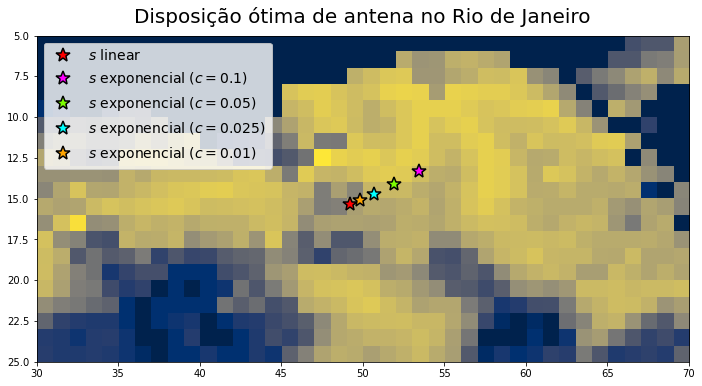

In [8]:
plt.figure(figsize = figsize)
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_lin[0], loc_opt_lin[1], '*', color = 'red', markersize = big_marker_size, markeredgecolor = 'black',
         markeredgewidth = marker_edge_width, label = "$s$ linear")

for c, color in zip([0.1, 0.05, 0.025, 0.01], ['fuchsia', 'lawngreen', 'cyan', 'orange']):
    def s(d): return np.exp(-c*d)
    
    def f_obj(v):
        log_barrier = np.sum(np.log(np.hstack([v, np.array([landscan_rio_xdim, landscan_rio_ydim]) - v])))
        return s(d_to_all_pts(v)) @ landscan_rio_flat + log_barrier
    grad_f = grad(f_obj)


    loc_curr = np.array([30.001, 30.001])
    f_obj_loc_curr = f_obj(loc_curr)
    grad_f_loc_curr = grad_f(loc_curr)
    λ = 1e-3
    locs = loc_curr

    for i in range(100):
        loc_next = loc_curr + λ*grad_f_loc_curr

        if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim] - loc_next)]) <= 0):
            f_obj_loc_next = -np.inf
        else:
            f_obj_loc_next = f_obj(loc_next)

        while f_obj_loc_next < f_obj_loc_curr:
            λ = λ/2
            loc_next = loc_curr + λ*grad_f_loc_curr

            if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim] - loc_next)]) <= 0):
                f_obj_loc_next = -np.inf
            else:
                f_obj_loc_next = f_obj(loc_next)

        if np.linalg.norm(loc_curr - loc_next) < 1e-3:
            break

        loc_curr = loc_next
        f_obj_loc_curr = f_obj_loc_next
        grad_f_loc_curr = grad_f(loc_curr)
        λ = λ*2

        locs = np.vstack([locs, loc_curr])
    
    loc_opt_exp = locs[-1]
        
    plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = color, markersize = big_marker_size, markeredgecolor = 'black',
             markeredgewidth = marker_edge_width, label = f"$s$ exponencial ($c = {c}$)")
        
plt.title("Disposição ótima de antena no Rio de Janeiro", fontsize = ttl_font_size, y = 1.02)
plt.legend(loc = 'upper left', fontsize = lgd_font_size)
plt.xlim(30,70)
plt.ylim(25,5)
plt.savefig("loc_opt_comparacao.pgf")

# 4) Problem with N antennae 

In [9]:
c = 0.1

def problem_N_antennae(loc_init, maxiters = 1_000, prec = 1e-3, return_all_locs = False):
    N = int(len(loc_init)/2)
    
    def f_obj(v):
        log_barrier = np.sum(np.log(np.hstack([v, np.array([landscan_rio_xdim, landscan_rio_ydim]*N) - v])))
        return s(np.min(np.vstack([d_to_all_pts(v[2*n:2*n+2]) for n in range(N)]), axis = 0)) @ landscan_rio_flat + log_barrier
    grad_f = grad(f_obj)
    
    loc_curr = loc_init
    locs = loc_curr
    f_obj_loc_curr = f_obj(loc_curr)
    f_objs = [f_obj_loc_curr]
    grad_f_loc_curr = grad_f(loc_curr)
    
    λ = 1.

    for i in range(maxiters):
        loc_next = loc_curr + λ*grad_f_loc_curr
        
        if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim]*N) - loc_next]) <= 0):
            f_obj_loc_next = -np.inf
        else:
            f_obj_loc_next = f_obj(loc_next)

        while f_obj_loc_next < f_obj_loc_curr and λ > 1e-12:
            λ = λ/2
            loc_next = loc_curr + λ*grad_f_loc_curr
            
            if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim]*N) - loc_next]) <= 0):
                f_obj_loc_next = -np.inf
            else:
                f_obj_loc_next = f_obj(loc_next)       

        if np.linalg.norm(loc_curr - loc_next) < prec or λ <= 1e-12:
            break

        loc_curr = loc_next
        f_obj_loc_curr = f_obj_loc_next
        grad_f_loc_curr = grad_f(loc_curr)
        λ = λ*2

        locs = np.vstack([locs, loc_curr])
        f_objs += [f_obj_loc_curr]
    
    if return_all_locs:
        return locs, f_objs[-1]
    else:
        return loc_curr, f_objs[-1]

## 4.1) Problem with 2 antennae

In [10]:
loc_init_1 = np.array([75.001, 5.001])
loc_init_2 = np.array([30.001, 30.001])
loc_init = np.hstack([loc_init_1, loc_init_2])

locs, final_f_obj = problem_N_antennae(loc_init, return_all_locs = True)

len(locs)

26

### 4.1.1) Multiple starting points

loc_opt = [55.87262307 13.19758397 25.64465932 17.85691842]


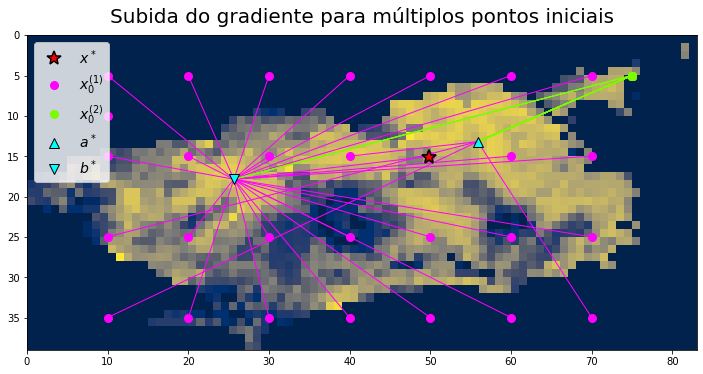

In [11]:
plt.figure(figsize = figsize)
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'red', markersize = big_marker_size, markeredgecolor = 'black', 
         markeredgewidth = marker_edge_width, label = "$x^*$")

init_xs = [10,20,30,40,50,60,70]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_locs = []
final_f_objs = []

for loc_init_2 in zip(init_xs_meshgrid, init_ys_meshgrid):
    loc_init_1 = np.array([75.001, 5.001])
    loc_init = np.hstack([loc_init_1, loc_init_2])
    
    final_loc, final_f_obj = problem_N_antennae(loc_init)
    
    final_locs += [final_loc]
    final_f_objs += [final_f_obj]
    
    plt.plot([loc_init[0], final_loc[0]], [loc_init[1], final_loc[1]], lw = lw, color = 'lawngreen')
    plt.plot([loc_init[2], final_loc[2]], [loc_init[3], final_loc[3]], lw = lw, color = 'fuchsia')
    plt.plot(loc_init[0], loc_init[1], 'o', markersize = sml_marker_size, color = 'lawngreen')
    plt.plot(loc_init[2], loc_init[3], 'o', markersize = sml_marker_size, color = 'fuchsia')
    
plt.plot(init_xs[0], init_xs[0], 'o', markersize = sml_marker_size, color = 'fuchsia', label = "$x^{(1)}_0$")
plt.plot(75.001, 5.001, 'o', markersize = sml_marker_size, color = 'lawngreen', label = "$x^{(2)}_0$")

loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.plot(loc_opt[0], loc_opt[1], '^', markersize = med_marker_size, color = 'cyan', markeredgecolor = 'black', label = "$a^*$")
plt.plot(loc_opt[2], loc_opt[3], 'v', markersize = med_marker_size, color = 'cyan', markeredgecolor = 'black', label = "$b^*$")
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'red', markersize = big_marker_size, markeredgecolor = 'black',
        markeredgewidth = marker_edge_width)

plt.title("Subida do gradiente para múltiplos pontos iniciais", fontsize = ttl_font_size, y = 1.02)
plt.legend(loc = 'upper left', fontsize = lgd_font_size)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0)
plt.savefig("mult_x0.pgf")

In [12]:
%%time

init_xs = [10,20,30,40,50,60,70]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_locs = []
final_f_objs = []

for loc_init_1 in zip(init_xs_meshgrid, init_ys_meshgrid):
    for loc_init_2 in zip(init_xs_meshgrid, init_ys_meshgrid):
        if loc_init_1 != loc_init_2:
            loc_init = np.hstack([loc_init_1, loc_init_2])

            final_loc, final_f_obj = problem_N_antennae(loc_init)

            final_locs += [final_loc]
            final_f_objs += [final_f_obj]

loc_opt_exp_2 = final_locs[np.argmax(final_f_objs)]
print("loc_opt_exp_2 =", loc_opt_exp_2)

loc_opt_exp_2 = [55.87291654 13.19759665 25.64572802 17.85724839]
Wall time: 38.1 s


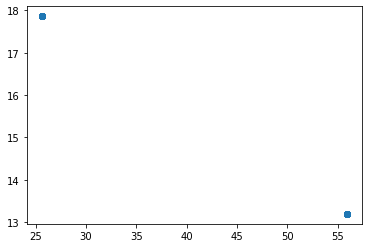

In [13]:
final_locs = np.array(final_locs)

plt.plot(final_locs[:,0], final_locs[:,1], 'o')

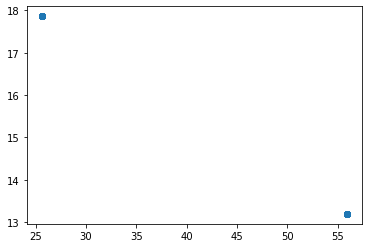

In [14]:
plt.plot(final_locs[:,2], final_locs[:,3], 'o')

## 4.2) Problem with N>2 antennae

In [15]:
%%time

loc_opts = [loc_opt_exp]

init_xs = [10,20,30,40,50,60,70]
init_ys = [5,10,15,20,25,30,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

for n in range(2,101):
    final_locs = []
    final_f_objs = []

    for loc_init_new in zip(init_xs_meshgrid, init_ys_meshgrid):
        loc_init = np.hstack([loc_opts[-1], loc_init_new])

        final_loc, final_f_obj = problem_N_antennae(loc_init)

        final_locs += [final_loc]
        final_f_objs += [final_f_obj]

    loc_opt = final_locs[np.argmax(final_f_objs)]
    loc_opts += [loc_opt]
    
    print(f"n = {n}")

n = 2
n = 3
n = 4
n = 5
n = 6
n = 7
n = 8
n = 9
n = 10
n = 11
n = 12
n = 13
n = 14
n = 15
n = 16
n = 17
n = 18
n = 19
n = 20
n = 21
n = 22
n = 23
n = 24
n = 25
n = 26
n = 27
n = 28
n = 29
n = 30
n = 31
n = 32
n = 33
n = 34
n = 35
n = 36
n = 37
n = 38
n = 39
n = 40
n = 41
n = 42
n = 43
n = 44
n = 45
n = 46
n = 47
n = 48
n = 49
n = 50
n = 51
n = 52
n = 53
n = 54
n = 55
n = 56
n = 57
n = 58
n = 59
n = 60
n = 61
n = 62
n = 63
n = 64
n = 65
n = 66
n = 67
n = 68
n = 69
n = 70
n = 71
n = 72
n = 73
n = 74
n = 75
n = 76
n = 77
n = 78
n = 79
n = 80
n = 81
n = 82
n = 83
n = 84
n = 85
n = 86
n = 87
n = 88
n = 89
n = 90
n = 91
n = 92
n = 93
n = 94
n = 95
n = 96
n = 97
n = 98
n = 99
n = 100
Wall time: 1h 26s


In [16]:
def plot_loc_opts(loc_opts, colors, alphas, plot_name):
    plt.figure(figsize = figsize)
    plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
    
    for loc_opt, color, alpha in zip(loc_opts, colors, alphas):
        num_antennae = len(loc_opt[::2])
        plt.plot(loc_opt[[2*i for i in range(num_antennae)]], loc_opt[[2*i+1 for i in range(num_antennae)]], '*', markersize = 
                 big_marker_size, color = color, markeredgecolor = 'black', markeredgewidth = marker_edge_width, label =
                 f"$N = {num_antennae}$", alpha = alpha)
    
    plt.title("Disposição ótima de $N$ antenas no Rio de Janeiro", fontsize = ttl_font_size, y = 1.02)
    plt.legend(loc = 'upper left', fontsize = lgd_font_size)
    plt.xlim(0, landscan_rio_xdim)
    plt.ylim(landscan_rio_ydim, 0)
    plt.savefig(plot_name)

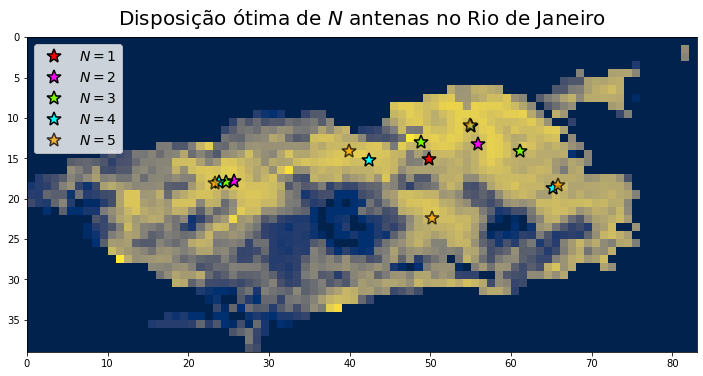

In [17]:
colors = ['red', 'fuchsia', 'lawngreen', 'cyan', 'orange']
alphas = [1, 1, 1, 1, 0.75]
plot_loc_opts(loc_opts[:5], colors, alphas, "loc_opt_5.pgf")

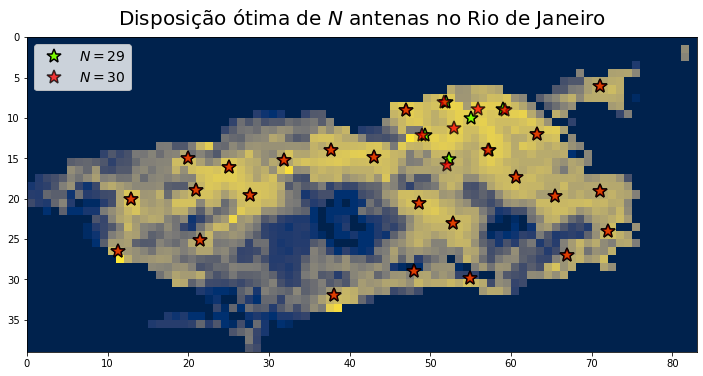

In [18]:
plot_loc_opts(loc_opts[28:30], ['lawngreen', 'red'], [1, 0.75], "loc_opt_30.pgf",)

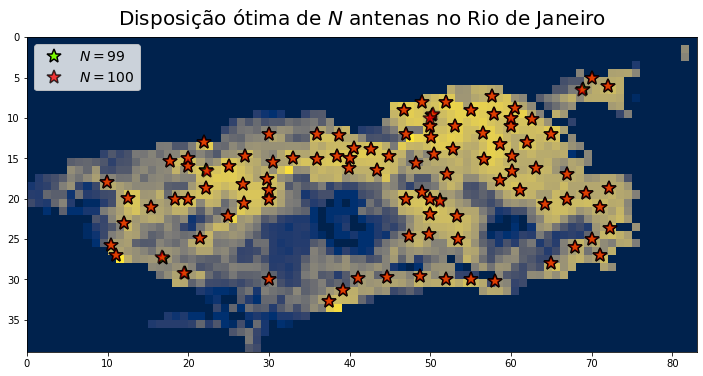

In [19]:
plot_loc_opts(loc_opts[98:100], ['lawngreen', 'red'], [1, 0.75], "loc_opt_100.pgf")

In [20]:
%%time

c = 0.1

loc_opts_c1 = [loc_opt_exp]

init_xs = [10,20,30,40,50,60,70]
init_ys = [5,10,15,20,25,30,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

for n in range(2,31):
    final_locs = []
    final_f_objs = []

    for loc_init_new in zip(init_xs_meshgrid, init_ys_meshgrid):
        loc_init = np.hstack([loc_opts_c1[-1], loc_init_new])

        final_loc, final_f_obj = problem_N_antennae(loc_init)

        final_locs += [final_loc]
        final_f_objs += [final_f_obj]

    loc_opt = final_locs[np.argmax(final_f_objs)]
    loc_opts_c1 += [loc_opt]
    
    print(f"n = {n}")

n = 2
n = 3
n = 4
n = 5
n = 6
n = 7
n = 8
n = 9
n = 10
n = 11
n = 12
n = 13
n = 14
n = 15
n = 16
n = 17
n = 18
n = 19
n = 20
n = 21
n = 22
n = 23
n = 24
n = 25
n = 26
n = 27
n = 28
n = 29
n = 30
Wall time: 7min 5s


In [21]:
%%time

c = 0.025

loc_opts_c2 = [loc_opt_exp]

init_xs = [10,20,30,40,50,60,70]
init_ys = [5,10,15,20,25,30,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

for n in range(2,31):
    final_locs = []
    final_f_objs = []

    for loc_init_new in zip(init_xs_meshgrid, init_ys_meshgrid):
        loc_init = np.hstack([loc_opts_c2[-1], loc_init_new])

        final_loc, final_f_obj = problem_N_antennae(loc_init)

        final_locs += [final_loc]
        final_f_objs += [final_f_obj]

    loc_opt = final_locs[np.argmax(final_f_objs)]
    loc_opts_c2 += [loc_opt]
    
    print(f"n = {n}")

n = 2
n = 3
n = 4
n = 5
n = 6
n = 7
n = 8
n = 9
n = 10
n = 11
n = 12
n = 13
n = 14
n = 15
n = 16
n = 17
n = 18
n = 19
n = 20
n = 21
n = 22
n = 23
n = 24
n = 25
n = 26
n = 27
n = 28
n = 29
n = 30
Wall time: 6min 55s


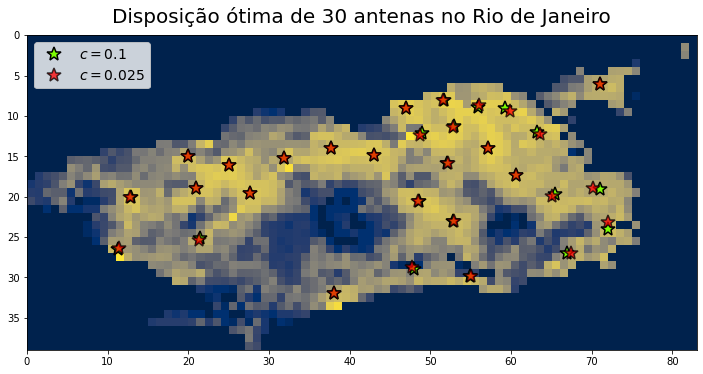

In [22]:
plt.figure(figsize = figsize)
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)

for loc_opt, color, al, c in zip([loc_opts_c1[-1], loc_opts_c2[-1]], ['lawngreen', 'red'], [1, 0.75], [0.1, 0.025]):
    num_antennae = len(loc_opt[::2])
    plt.plot(loc_opt[[2*i for i in range(num_antennae)]], loc_opt[[2*i+1 for i in range(num_antennae)]], '*', markersize = 
             big_marker_size, color = color, markeredgecolor = 'black', markeredgewidth = marker_edge_width, label =
             f"$c = {c}$", alpha = al)

plt.title("Disposição ótima de 30 antenas no Rio de Janeiro", fontsize = ttl_font_size, y = 1.02)
plt.legend(loc = 'upper left', fontsize = lgd_font_size)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0)
plt.savefig("loc_opt_dif_c.pgf")